<a href="https://colab.research.google.com/github/abhi2596/NADE/blob/main/DGMNade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from torch import nn 

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=T.Compose([T.Lambda(lambda x: np.round(np.array(x)/27).astype(int)), T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.Compose([T.Lambda(lambda x: np.round(np.array(x)/27).astype(int)), T.ToTensor(), T.Lambda(lambda x: torch.flatten(x))])
)


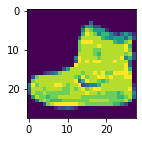

In [ ]:
image = np.array(torch.reshape(training_data[0][0],(28,28)))
plt.figure(figsize=(2,2))
plt.imshow(image)
plt.show()

In [ ]:
batch_size = 100

train_data_loader = torch.utils.data.DataLoader(training_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
class NADE(nn.Module):
  def __init__(self):
    super(NADE,self).__init__()
    self.V = torch.nn.Parameter(torch.randn((784,500),requires_grad=True))
    self.W = torch.nn.Parameter(torch.randn((500,784),requires_grad=True))
    self.b = torch.nn.Parameter(torch.randn(784,requires_grad=True))
    self.c = torch.nn.Parameter(torch.randn((10,500),requires_grad=True))
    self.batch_size = 100
     
  def calculate_probability(self,x):
    a_d = self.c.expand(x.size(0),-1,-1)
    p_x = torch.empty((self.batch_size,10,1),device=device)
    for d in range(784):
      one_hot = torch.nn.functional.one_hot(x[:,d], num_classes= 10)
      h_d = torch.sigmoid(a_d)
      p_x_xd = torch.log_softmax(torch.matmul(h_d,self.V[d, :].t()) + self.b[d:d+1],dim=1)
      p_x_xd = p_x_xd.unsqueeze(dim=2)
      p_x = torch.cat((p_x,p_x_xd),dim=2)
      one_hot = one_hot.unsqueeze(dim=2)
      a_d = torch.matmul(one_hot.type(torch.cuda.FloatTensor),self.W[:,d:d+1].t()) + a_d
    return p_x[:,:,1:],x

  def sampling(self):
    a_d = self.c 
    generated_sample = []
    for d in range(784):
      h_d = torch.sigmoid(a_d)
      p_hat = torch.log_softmax(torch.matmul(h_d,self.V[d,:].t()) + self.b[d:d+1], dim=0)
      x = torch.distributions.categorical.Categorical(logits=p_hat).sample()
      generated_sample.append(x)
      x = torch.nn.functional.one_hot(x, num_classes= 10).unsqueeze(dim=1)
      a_d = torch.matmul(x.type(torch.cuda.FloatTensor),self.W[:,d:d+1].t()) + a_d
    return torch.tensor(generated_sample)

  def forward(self,x):
    y = self.calculate_probability(x)
    return y

In [ ]:
def test_loop(dataloader, model, loss_fn):
  loss_per_epoch = 0
  size = len(dataloader.dataset)
  D = 784
  with torch.no_grad():
    for batch, (X, y) in enumerate(dataloader):
      p_x,x = model(X)
      loss = loss_fn(p_x,x.type(torch.cuda.LongTensor))/100
      loss_per_epoch += loss.item()
      if batch % 10 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss of test: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  return loss_per_epoch/100

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    loss_per_epoch = 0
    for batch, (X, y) in enumerate(dataloader):
      pred,x = model(X)
      loss = loss_fn(pred,x.type(torch.cuda.LongTensor))/100
      loss_per_epoch += loss.item()
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return loss_per_epoch/600

In [ ]:
model = NADE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
Nll = torch.nn.NLLLoss(reduction = "sum")

loss_of_train = []
loss_of_test = []
epochs = []

for epoch in range(0,5):
  print("----- Epoch: " + str(epoch) + " -----" )
  loss_of_train.append(train_loop(train_data_loader,model,Nll,optimizer))
  loss_of_test.append(test_loop(test_data_loader,model,Nll))
  epochs.append(epoch+1)

----- Epoch: 0 -----
loss: 9849.250000  [    0/60000]
loss: 653.083557  [10000/60000]
loss: 623.637756  [20000/60000]
loss: 630.271362  [30000/60000]
loss: 635.866760  [40000/60000]
loss: 626.544495  [50000/60000]
loss of test: 632.021912  [    0/10000]
loss of test: 604.698120  [ 1000/10000]
loss of test: 571.159241  [ 2000/10000]
loss of test: 600.474915  [ 3000/10000]
loss of test: 626.306641  [ 4000/10000]
loss of test: 580.783447  [ 5000/10000]
loss of test: 630.773987  [ 6000/10000]
loss of test: 595.411133  [ 7000/10000]
loss of test: 609.954895  [ 8000/10000]
loss of test: 644.738953  [ 9000/10000]
----- Epoch: 1 -----
loss: 622.791809  [    0/60000]
loss: 571.254089  [10000/60000]
loss: 561.880859  [20000/60000]
loss: 663.697693  [30000/60000]
loss: 614.426575  [40000/60000]
loss: 557.283508  [50000/60000]
loss of test: 599.849304  [    0/10000]
loss of test: 556.089722  [ 1000/10000]
loss of test: 560.426697  [ 2000/10000]
loss of test: 617.610474  [ 3000/10000]
loss of test:

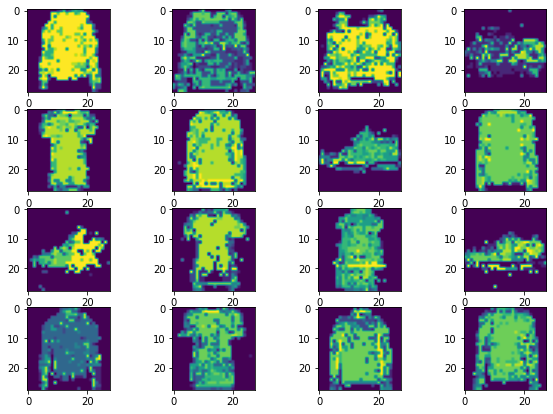

In [ ]:
import matplotlib.pyplot as plt 
fig = plt.figure(figsize=(10, 7))
rows = 4
columns = 4

outputs = []
for i in range(16):
  output = model.sampling()
  output = torch.reshape(output,(28,28))
  output = np.array(output)
  outputs.append(output)
  fig.add_subplot(rows, columns, i+1)
  plt.imshow(outputs[i])

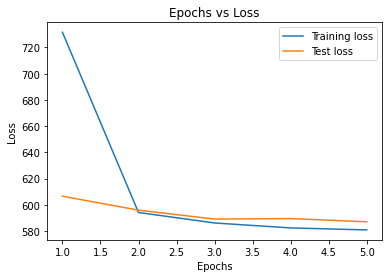

In [ ]:
plt.plot(epochs,loss_of_train,label="Training loss")
plt.plot(epochs,loss_of_test,label="Test loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs Loss")
plt.legend()
plt.show()